In [1]:
# general imports
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# ICA

# *Independent Components Analysis*

## Mischungen von Quellsignalen trennen?

### Unabhängigkeit der Quelldaten
Nur unkorreliert: PCA funktioniert *nicht*

#### Beispiel:
Cocktailparty

# Übersicht
- Anwendungsfelder
- Problemstellung
- Beispiel: Cocktailparty
- Statistik
- Ziel: Entmischung
- Mathematik
    - Mischung und Entmischung
- Wahrscheinlichkeitsverteilung
    - Momente der Verteilung
    - gemeinsame Verteilung
    - Kurtosis
- Projection Pursuit
- Unterraum
- Ergebnis
- Zusammenfassung

# Anwendungsmöglichkeiten

- Spracherkennung
- EEG
- funktionale Hirnscans (fMRI)
- Gesichtserkennung
- Bildanalyse
- Börsenkursanalyse
- Telekommunikation
- Neuronal spike sorting
- Rezeptive Felder modellieren
- Erkennen der Reife von Früchten
- .... 

# Beispiel: Zwei Stimmen

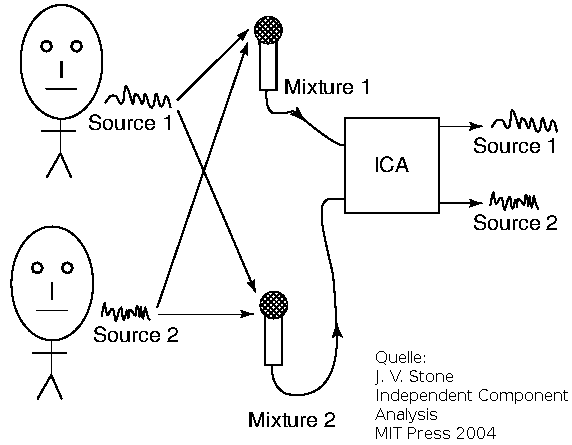

In [3]:
'''The two source signals'''
from scipy.io import wavfile
freq, s1 = wavfile.read("data/wav_independent.wav")
freq, s2 = wavfile.read("data/wav_component.wav")
l = min(s1.shape[0], s2.shape[0]) # cut for same length
s1=s1[:l]
s2=s2[:l]

In [4]:
from IPython.lib.display import Audio
Audio(s1, rate=freq, autoplay=False)

In [5]:
Audio(s2, rate=freq, autoplay=False)

## Mischungen

In [6]:
A11=0.4
A12=0.9
x1 = A11*s1 + A12*s2
Audio(0.4*x1, rate=freq, autoplay=False)

In [8]:
A21=0.7
A22=0.5
x2 = A21*s1 + A22*s2
Audio(0.4*x2, rate=freq, autoplay=False)

## Daten graphisch

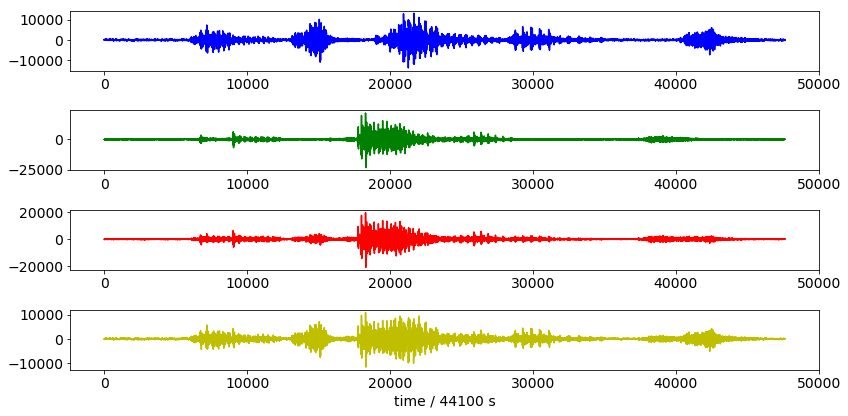

In [8]:
'''two sources; two mixtures'''
f = plt.figure(figsize=(12, 6))
for i, (data, col) in enumerate(zip([s1, s2, x1, x2], ['b', 'g', 'r', 'y'])):
    f.add_subplot(4, 1, i+1)
    plt.plot(data, col+'-')
plt.xlabel('time / 44100 s')
plt.tight_layout();

## Abhängigkeit

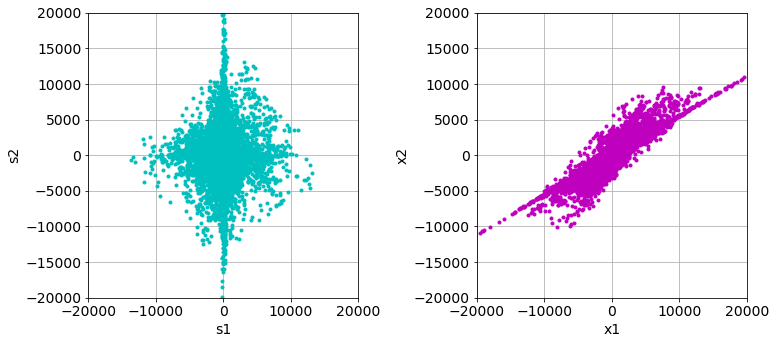

In [9]:
'''visualize common distribution sources / mixtures'''
f = plt.figure(figsize=(11, 5))
# the sources s1, s2
f.add_subplot(1, 2, 1)        # 1st = left
plt.grid(True)
plt.plot(s1, s2, 'c.')
plt.axis((-20000, 20000, -20000, 20000))
plt.xlabel('s1')
plt.ylabel('s2')
plt.tight_layout();
# the mixtures x1, x2
f.add_subplot(1, 2, 2)        # 2nd = right
plt.grid(True)
plt.plot(x1, x2, 'm.')
plt.axis((-20000, 20000, -20000, 20000))
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout();

## Statistik

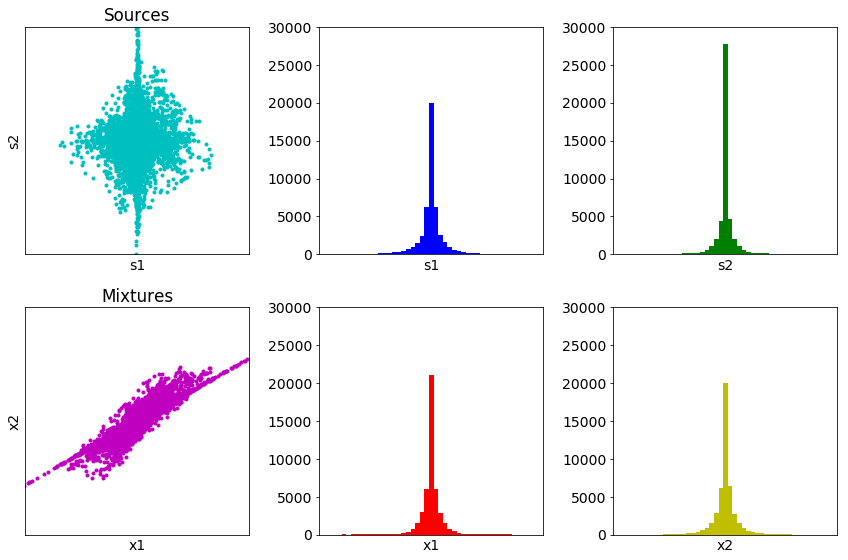

In [10]:
'''statistics of sources and mixtures'''
f = plt.figure(figsize=(12, 8))
for i, data, col, tit, lbl in zip([1, 4], 
                                  [(s1, s2), (x1, x2)], 
                                  ['c', 'm'], 
                                  ['Sources', 'Mixtures'], 
                                  [('s1', 's2'), ('x1', 'x2')]):
    f.add_subplot(2, 3, i)
    plt.title(tit)
    plt.axis((-20000, 20000, -20000, 20000));
    plt.plot(data[0], data[1], col+'.')
    plt.gca().set_xticks([]) # neither tick marks nor numbers ...
    plt.gca().set_yticks([])
    plt.xlabel(lbl[0]) # ... but label
    plt.ylabel(lbl[1]);

bins = np.linspace(-8000, 8000, 40)
for i, data, col, lbl in zip([2, 3, 5, 6], [s1, s2, x1, x2], 
                             ['b', 'g', 'r', 'y'], ['s1', 's2', 'x1', 'x2']):
    f.add_subplot(2, 3, i)
    plt.hist(data, bins, color=col)
    plt.axis((-10000, 10000, 0, 30000))
    plt.gca().set_xticks([])
    plt.xlabel(lbl);

plt.tight_layout();

# Ziel: Entmischen

### Unabhängigkeit

### Komplexität

### Nicht-Normalverteilt

#### Erinnerung: *Zentraler Grenzwertsatz*

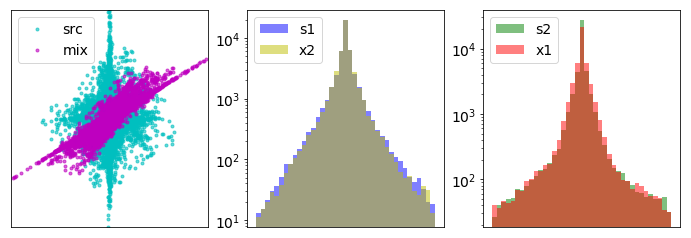

In [11]:
'''compare distributions of sources vs. mixtures'''
fig = plt.figure(figsize=(12, 4)) # lots of space for 3 sub graphs
fig.add_subplot(1, 3, 1) # 1st sub figure: left
plt.axis((-20000, 20000, -20000, 20000)) # equal borders in x and y direction 
plt.gca().get_xaxis().set_visible(False) # no labels, ticks, numbers at axis
plt.gca().get_yaxis().set_visible(False)
# left most graph: sources vs. mixtures data
for i, data, col, lb in zip([1, 4], [(s1, s2), (x1, x2)], 
                            ['c', 'm'], ['src', 'mix']):
    plt.plot(data[0], data[1], col+'.', alpha=.6, label=lb)
    plt.legend(loc='upper left');

# middle and right graph: distribution of source-mixture pairs
bins = np.linspace(-8000, 8000, 40)
for i, data, col, lb in zip([2, 3], 
                            [(s1, x2), (s2, x1)], 
                            [('b', 'y'), ('g', 'r')], 
                            [('s1', 'x2'), ('s2','x1')]):
    fig.add_subplot(1, 3, i) # 2nd or 3rd sub figure
    # no labels, ticks on x-axis (but on y to show log)
    plt.gca().get_xaxis().set_visible(False)
    for j in range(2): # draw the both signals
        plt.hist(data[j], bins, color=col[j], log=True, alpha=.5, label=lb[j])
    plt.legend(loc='upper left');

# Mathematik

#### Quell-Daten
$I$ Quellsignal-Vektoren $\mathbf{s}_i$ der Länge $N$:
$$\mathbf{s}_i = (s_{i1}, s_{i2}, \dots, s_{iN})$$

zusammen in der Datenmatrix
$$\mathbf{S}=
\begin{pmatrix}
\mathbf{s}_1\\ \mathbf{s}_2\\ \vdots \\ \mathbf{s}_I
\end{pmatrix}$$

#### Mischungs-Daten
$J$ Mischungs.vektoren $\mathbf{x}_j$ der Länge $N$:

$$\mathbf{X}=
\begin{pmatrix}
\mathbf{x}_1\\ \mathbf{x}_2\\ \vdots \\ \mathbf{x}_J
\end{pmatrix}$$

entstanden aus den Quellsignalen
$$\mathbf{x}_j = \mathbf{a}_j\cdot \mathbf{S} = a_{j1}\mathbf{s}_1+a_{j2}\mathbf{s}_2+a_{j3}\mathbf{s}_3+\dots$$

mit den Mischungskoeffizienten $\mathbf{a}_j=(a_1, a_2, a_3, ...)$. Hier im Bsp.: 

$$\mathbf{x}_1 = a_{11} \cdot \mathbf{s}_1 + a_{12} \cdot \mathbf{s}_2$$
$$\mathbf{x}_2 = a_{21} \cdot \mathbf{s}_1 + a_{22} \cdot \mathbf{s}_2$$



#### Matrix-Schreibweise
$$\mathbf{X}=\mathbf{A}\cdot\mathbf{S}$$

Dabei hat $\mathbf{A}$ die Dimension  $J\times I$,<br>
die $I$ Quelldaten $\mathbf{S}$ die Dimension $I\times N$<br>
und die $J$ Mischdaten $\mathbf{X}$ die Dimension $J\times N$.

### Unser Beispiel
$$\mathbf{A} =  \begin{pmatrix} 0.4 \quad 0.9 \\ 0.7 \quad 0.5 \end{pmatrix}$$

shape of source data S:           (2, 47628)
shape of mixture data X:          (2, 47628)
shape of transformation matrix A: (2, 2)
[[ 0.4  0.9]
 [ 0.7  0.5]]


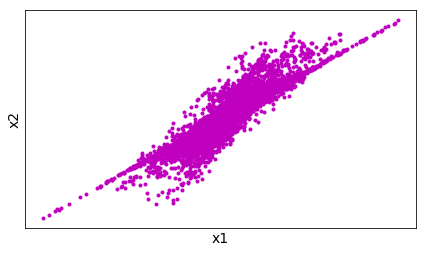

In [12]:
'''mixture data'''
S = np.array([s1, s2])
A = np.array([[0.4, 0.9],[0.7, 0.5]])
X = np.dot(A, S)
print('shape of source data S:           {}'.format(S.shape))
print('shape of mixture data X:          {}'.format(X.shape))
print('shape of transformation matrix A: {}'.format(A.shape))
print(A)
fig = plt.figure(figsize=(7, 4))
plt.plot(X[0], X[1], 'm.')
plt.gca().set_xticks([]) # neither tick marks nor numbers ...
plt.gca().set_yticks([])
plt.xlabel('x1')
plt.ylabel('x2');

## Problem
$\mathbf{A}$ ist leider unbekannt

$\mathbf{S}_i$ sind leider unbekannt; gesucht!

## Lösung?

Wüßten wir die Mischungsmatrix $\mathbf{A}$, könnten wir die Entmischungs-Matrix für den Fall $I=J$ berechnen
$$\mathbf{A}^{-1}$$ 

Wüßten wir die Quelldaten, könnten wir die Entmischungs-Matrix für den Fall $I=J$ berechnen.

(überbestimmt)

## Anzahl Komponenten / Datensätze

- Problem bei $J<I$
    - Weniger Mischungs-Datensätze als Quell-Signale lassen sich normalerweise nicht trennen
    - Bsp: Anzahl der Mikrofone $\geq$ Anzahl der zu extrahierenden Stimmen

- Praxis: mehr Datensätze $J>I$
    - zB im EEG $>10$ Elektroden und $<5$ Signale

- $I$ bekannt
    - mittels PCA vorfiltern um Dimension auf $J$ zu reduzieren 

-  $I$ unbekannt
    - Es verbleiben eventuell restliche Dimensionen, die nur noch Rauschen enthalten. 
    - Lösung:
        - Festlegen einer Schwelle
        - Vorverarbeiten mittels PCA

## Lösung

Quellsignale erscheinen im Mischungsgraphen als Orientierung (gemeinsame Ursache)

In [13]:
'''another mixture'''
B11 = 0.4
B12 = 0.6
B21 = -0.7
B22 = 0.2
B = np.array([[B11, B12],[B21, B22]])
xxb = np.dot(B, S)
x21 = xxb[0]
x22 = xxb[1]

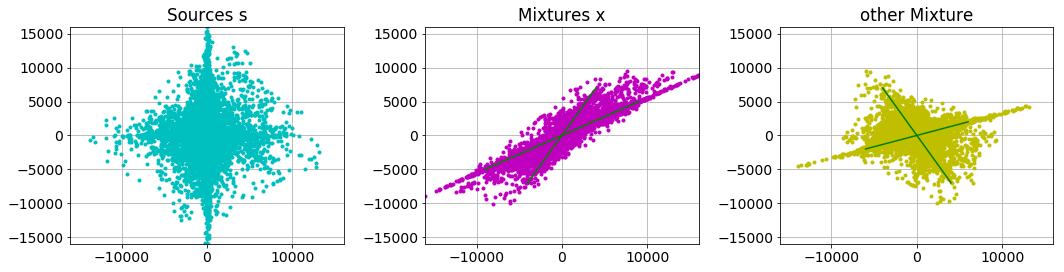

In [14]:
f = plt.figure(figsize=(15, 4))
f.add_subplot(1, 3, 1)
plt.title('Sources s')
plt.grid(True)
plt.xlim(-16000, 16000)
plt.ylim(-16000, 16000)
plt.plot(s1,s2,'c.');

f.add_subplot(1, 3, 2)
plt.title('Mixtures x')
plt.grid(True)
plt.xlim(-16000, 16000)
plt.ylim(-16000, 16000)
plt.plot(X[0],X[1],'m.');
Wx = 10000*np.array([-A[0][0], A[0][0]])
Wy = 10000*np.array([-A[1][0], A[1][0]])
plt.plot( Wx, Wy, 'g-')
Wx = 10000*np.array([-A[0][1], A[0][1]])
Wy = 10000*np.array([-A[1][1], A[1][1]])
plt.plot( Wx, Wy, 'g-')

f.add_subplot(1, 3, 3)
plt.title('other Mixture')
plt.grid(True)
plt.xlim(-16000, 16000)
plt.ylim(-16000, 16000)
plt.plot(x21,x22,'y.')
Wx = 10000*np.array([-B[0][0], B[0][0]])
Wy = 10000*np.array([-B[1][0], B[1][0]])
plt.plot( Wx, Wy, 'g-')
Wx = 10000*np.array([-B[0][1], B[0][1]])
Wy = 10000*np.array([-B[1][1], B[1][1]])
plt.plot( Wx, Wy, 'g-')
plt.tight_layout();

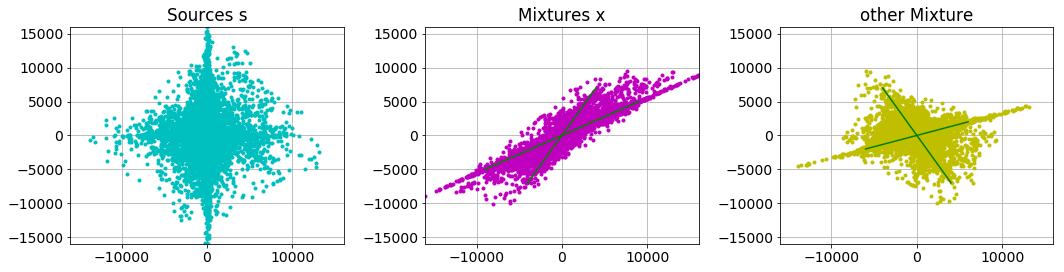

In [14]:
'''empirical joint distribution of sources and mixtures'''

Die Richtungen der Quellen $s_i$ sind in der Graphik angedeutet.


# Entmischen

$$\mathbf{S} = \mathbf{W}\mathbf{X}$$

mit den Datenreihen der Mischungen $\mathbf{X}_j$ und den (rekonstruierten) Quellen $\mathbf{S}_i$.

Die Entmischungsmatrix $\mathbf{W}$ hat die Dimension $I\times J$ und enthält die Gewichtung der $I$ Quellsignale in den $J$ Mischdaten.

### Mischung
war $$\mathbf{X} = \mathbf{A}\mathbf{S}$$

# Ansatz: *Un*-Normal-Verteilung

Da Mischungen *Normal*-verteilt(er) sind, suche nach Entmischungen, mit
- möglichst nicht-gauß-förmigen Verteilungen $\mathbf{s}$
- unterschiedlichen höheren Momenten

## Einschub: Momente einer Verteilung

Die Zufallsvariable $X$ habe die Wahrscheinlichkeitsdichte $f_x(x)$ und sei o.b.d.A. zentriert $\mu=0$.

#### Normierung

$$\int_{x=-\infty}^{\infty}f_x(x)\:\mathrm{d}x = 1$$

#### erstes Moment: Erwartungswert $\mathcal{E}(X)$

$$\mu = \mathcal{E}\{X\}=\int_{x=-\infty}^{\infty}x\cdot f_x(x)\:\mathrm{d}x = 0$$

#### zweites Moment: Varianz $\mathcal{E}\left( (X-\mu)^2\right)$

$$\sigma^2 = \mathcal{E}\{X^2\}=\int_{x=-\infty}^{\infty} x^2\cdot f_x(x) \:\mathrm{d}x$$

#### drittes Moment: Schiefe (*Skewness*) $\mathcal{E}\left( \frac{(X-\mu)^3}{\sigma^3}\right)$

$$\mathcal{E}\{X^3\}=\int_{x=-\infty}^{\infty} x^3 \cdot f_x(x) \:\mathrm{d}x$$

- beschreibt die Asymmetrie der Verteilung von $X$.

#### viertes Moment: 
(zentriert)
$$\mathcal{E}\{X^4\} = \int_{-\infty}^{\infty} (x)^4\cdot f(x)\; \mathrm{d}x\; = m_4$$
ergibt die (allgemeine) **Kurtosis**
$$ \mathrm{K}(X) = \mathcal{E}\Bigl( \frac{(X-\mu)^4}{(\sigma^2)^2} \Bigr) - 3$$

- beschreibt wie spitz oder flach die Verteilung verläuft
- *Normal*verteilung hat Kurtosis $K=0$
- spitzere Verteilungen "*super Gauß*" $K>0$

(m)
Wenn es 3 ist, ist es normal Verteilung.


## Momente einer *gemeinsamen* Verteilung

Das Signal $x$ hat die Verteilung $\;f_x(x)$, das Signal $y$ hat die Verteilung $\;f_y(y)$. 

#### Sind $x$ und $y$ stochastisch unabhängig
dann (und nur dann) zerfällt die gemeinsame Verteilung (*joint distribution*) in das Produkt aus den einzelnen Randverteilungen (*marginal distributions*):

$$f_{xy}(x,y) = f_x(x)\cdot f_y(y)$$

#### Kovarianz
beschreibt **lineare** Abhängigkeit der beiden Verteilungen

$$\mathrm{Cov}(x, y) = \mathcal{E}(x\cdot y)=\int_{x=-\infty}^{\infty}\int_{y=-\infty}^{\infty}f_x(x)\cdot f_y(y)\cdot x\cdot y\:\mathrm{d}x\:\mathrm{d}y$$

## Unabhängigkeit
Allgemein sind zwei Verteilungen unabhängig, wenn *alle* Momente faktorisieren:

$$\mathcal{E}(x^p\cdot y^q)=\int_{x=-\infty}^{\infty}\int_{y=-\infty}^{\infty}f_x(x)\cdot f_y(y)\cdot x^p\cdot y^q\:\mathrm{d}x\:\mathrm{d}y = \mathcal{E}(x^p)\cdot \mathcal{E}(y^q)$$

## Kurtosis als Beispiel
Signal $\mathbf{y}$ der Länge $N$

$$K=\frac{\frac{1}{N}\sum_{t=1}^N(y_t-\bar{y})^4}{\left( \frac{1}{N}\sum_{t=1}^N(y_t-\bar{y})^2 \right)^2}-3$$

$$\begin{aligned}
\mathcal{E}(x^4)\cdot \mathcal{E}(y^4) &= \mathcal{E}((a_{11}s+a_{12}t)^4)\cdot \mathcal{E}((a_{21}s+a_{22}t)^4) \\
&= c_1\cdot\mathcal{E}(s^4)\cdot \mathcal{E}(t^4) + c_2\cdot f(a_i, s, t)
\end{aligned}$$

In [1]:
from scipy import stats

k1, k2, k3, k4 = (stats.kurtosis(S[0]),
                  stats.kurtosis(S[1]),
                  stats.kurtosis(X[0]),
                  stats.kurtosis(X[1]))
print('Kurtosis of sources\ts1={:.2f}\ts2={:.2f}\n'
      '    and of mixtures\tx1={:.2f}\tx2={:.2f}'
              .format(k1, k2, k3, k4))

Kurtosis of sources	s1=12.67	s2=35.09
    and of mixtures	x1=27.73	x2=11.75

# Projection Pursuit

Suche Maximum der Kurtosis innerhalb der Mischungen

Durchprobieren aller möglichen Entmischungen

In [16]:
'''calculate kurtosis for (de)mixtures in 720 steps around 360°'''
nst = 2*360 # cycle around in half degrees

def kurtosis_step(phi):
    '''
    calculates kurtosis and its x- and y-components for one angle phi
    input: phi
    output: (kurtosis, kurtosis-x, kurtosis-y)
    '''
    # projections under angle phi to x, y
    cos_phi, sin_phi = np.cos(phi), np.sin(phi)
    # test demixing unit vector in direction phi
    testvector = cos_phi * X[0] + sin_phi * X[1]
    # scipy.stats contains kurtosis()
    kurt = stats.kurtosis(testvector)
    # kurtosis and its x- and y-contribution
    return kurt, cos_phi * kurt, sin_phi * kurt

# calculate kurtosis for (de)mixtures of cc and dd in 720 steps around 360°
kurts, kx, ky = np.asarray(
    [kurtosis_step(p) for p in np.linspace(0, 2 * np.pi, nst+1)]).T
kmaxindex = np.argmax(kurts) # search index of maximum
kmax = kurts[kmaxindex]      # and value of max kurtosis
print('maximum kurtosis ={:.2f} @ {:.1f}°'
      .format(kurts[kmaxindex], kmaxindex/2))

maximum kurtosis =35.09 @ 150.0°


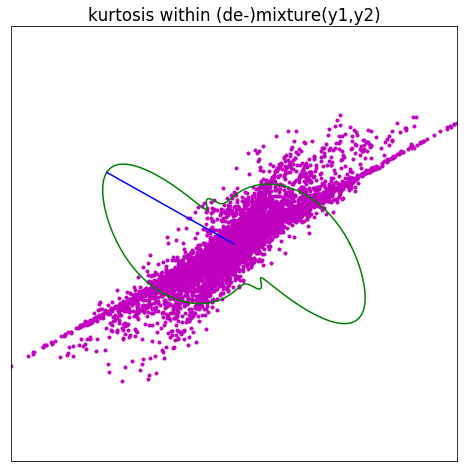

In [18]:
plt.figure(figsize=(8, 8))
plt.title('kurtosis within (de-)mixture(y1,y2)')
plt.plot(X[0], X[1], 'm.') # mixture data X
plt.plot(300*kx,300*ky,'g-') # kurtosis(phi) in x and y directions
plt.gca().get_xaxis().set_visible(False) # no axis
plt.gca().get_yaxis().set_visible(False)
plt.xlim(-16000,16000)
plt.ylim(-16000,16000)
plt.plot((0., 300.*kx[kmaxindex]),(0., 300.*ky[kmaxindex]), 'b-');

## Stimmt der gefundene Vektor mit einer Richtung aus der (uns bekannten) Mischungsmatrix überein?


In [19]:
phimax = kmaxindex/360.*np.pi
W1 = np.array([np.cos(phimax), np.sin(phimax)])
print('"best" unmixing direction would be: {}'.format(W1))

"best" unmixing direction would be: [-0.8660254  0.5      ]


In [20]:
Ainv = np.linalg.inv(A)
print('Normalized A.inverted vectors:')
print('V1 = {0}'.format(Ainv[0] / np.linalg.norm(Ainv[0])))
print('V2 = {0}'.format(Ainv[1] / np.linalg.norm(Ainv[1])))

Normalized A.inverted vectors:
V1 = [-0.48564293  0.87415728]
V2 = [ 0.86824314 -0.49613894]


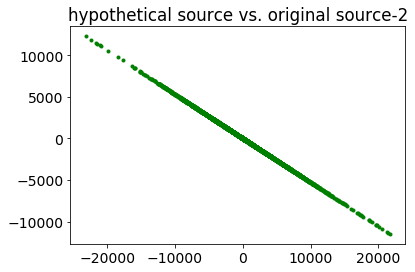

In [21]:
'''project mixtures (back) to (one) source'''
s_a = W1.dot(X) # project mixtures to hypothetical source candidate
plt.plot(S[1], s_a, 'g.') # and compare with the (2nd) real source
plt.title('hypothetical source vs. original source-2');

In [1]:
%whos

Interactive namespace is empty.


In [22]:
Audio(s_a, rate=freq, autoplay=False)

# Wie weiter?

Erste Richtung gefunden.

Bestimme unabhängigen Unterraum davon.

Suche nächstes Maximum der Kurtosis.

usw.

#### Mathematik: 
Gram Schmidt Orthogonalisierung 

#### Senkrechter Unterraum
Senkrecht $\;\;\mathbf{=}\;\;($ Kovarianz $=0)$

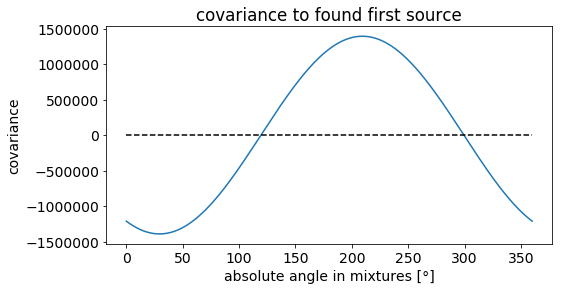

In [23]:
'''calculate covariance for (de)mixtures in .5° steps around 360°'''
def step(phi):
    '''
    calculates covariance and its x- and y-components for one angle phi
    input: phi
    output: (covariance, cov-x, cov-y)
    '''
    cos_phi, sin_phi = np.cos(phi), np.sin(phi)
    # test demixing data in direction phi
    testvector = cos_phi*X[0] + sin_phi*X[1]
    # calculate covariance test % found
    cov = np.cov(s_a, testvector)[0, 1]
    # covariance and projections to x and y
    return cov, cos_phi * cov, sin_phi * cov

# 720+1 within 360° = 2*Pi
phis = np.linspace(0, 2.*np.pi, nst+1)
# calculate covariance and projections
covs, cx, cy = np.asarray([step(p) for p in phis]).T
plt.figure(figsize=(8, 4))
plt.plot(180/np.pi*phis, covs) # covariance vs. direction[°]
plt.plot([0, 360], 2*[0], 'k--')
plt.title('covariance to found first source')
plt.ylabel('covariance')
plt.xlabel('absolute angle in mixtures [°]');

zero covariance =-2188.34 @ (0.492, -0.870)
[-1.00019022  0.01941614]


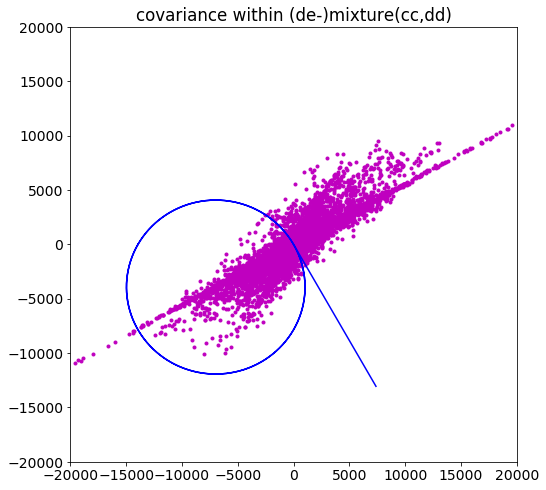

In [24]:
plt.figure(figsize=(8, 8))
plt.title('covariance within (de-)mixture(cc,dd)')
plt.plot(X[0], X[1], 'm.') # mixing data
kmax = covs.max() # normalize
kxplt = cx*16000./kmax
kyplt = cy*16000./kmax
plt.plot( kxplt, kyplt, 'b-') # covariances
# which index (angle) is nearest to zero?
kzero = np.min(np.abs(covs))
try:
    # check if near-zero in positive half
    kzeroindex = np.where(covs==kzero)[0][0]
except IndexError: # -or-
    # in (slightly) negative half
    kzeroindex = np.where(covs==-kzero)[0][0]
# projection to that angle of index
cosphi=np.cos(phis[kzeroindex])
sinphi=np.sin(phis[kzeroindex])
print('zero covariance ={:.2f} @ ({:.3f}, {:.3f})'
      .format(covs[kzeroindex], cosphi, sinphi))
plt.xlim(-20000,20000)
plt.ylim(-20000,20000)
# draw the vector for zero covariance
plt.plot((0., 15000*cosphi),(0., 15000*sinphi), 'b-');
print( 2.426*np.dot(np.array([cosphi,sinphi]),A) )

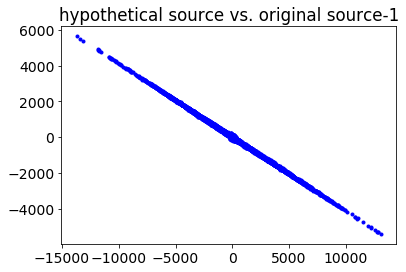

In [25]:
# second hypothetical source orthogonal to first
s_b = cosphi*X[0] + sinphi*X[1]
plt.plot(S[0], s_b, 'b.')
plt.title('hypothetical source vs. original source-1');



## Anhören:

In [26]:
s_b = cosphi*X[0] + sinphi*X[1]
Audio(s_b, rate=freq, autoplay=False)

# Ergebnis

Damit wären die Quellsignale $\mathbf{y_1}\sim\mathbf{s_2}\;$ und $\;\mathbf{y_2}\sim\mathbf{s_1}\;$ aus den Mischungen ($\mathbf{x_1}$, $\mathbf{x_2}$) extrahiert.

$\blacksquare$

## Weiteres Vorgehen bei mehreren Dimensionen
- Beschränken auf Unterraum senkrecht zur ersten Komponente
- Finde darin nächste (=zweite) unabhängige Komponente
- Beschränken auf Unterraum senkrecht zur ersten und zweiten Komponenten
- Finde darin nächste unabhängige Komponente
- ...

# Zusammenfassung Unabhängige Komponenten
- Erstelle Raum der Mischsignale
- Suche Projektionsrichtung in den Mischungen, die die Unabhängigkeit maximiert
    - das ist nach dem *Zentralen Grenzwertsatz* die am wenigsten *Normal*-verteilte
    - dafür eignet sich die Kurtosis
    - Rückprojektion entspricht erster *unabhängiger* Komponente
- Rekursiv durch Unterräume
    - findet weitere unabhängige Komponenten
    - Abbruch
        - wenn genug Komponenten (Dimension)
        - wenn Schwelle für Kurtosis unterschritten
- Ergebnis: unabhängige Komponenten (extremer) Kurtosis
    - jedoch nicht deren ursprüngliches Verhältnis

## *blind source separation*

#### Separation
zerlegen in ursprüngliche Bestandteile

#### Quellen
Vermutung, daß unabhängige Bestandteile die Quelle bzw. Ursache der Mischungen sind

#### blind 
Keine Informationen über die zugrundeliegenden Quelldaten bekannt 
- Stimmlage
- Statistische Verteilung
- *parameterfrei*

Dies war Projection Pursuit.

# Fragen?

Nächstes Kapitel: (fast) ICA